In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pickle import dump
import datetime
from datetime import timedelta

In [8]:
data = pd.read_excel("Seoul_2023/01월 서울시 교통량 조사자료(2023).xlsx", sheet_name=1)
data.head()
data.to_csv("Seoul_2023/Seoul_2023_01.csv", encoding='utf-8')

In [9]:
data.to_csv("Seoul_2023/Seoul_2023_01.csv", encoding='utf-8-sig')

In [10]:
for i in range(1, 13):
    data = pd.read_excel(f"Seoul_2023/{i:02d}월 서울시 교통량 조사자료(2023).xlsx", sheet_name=1)
    data.to_csv(f"Seoul_2023/Seoul_2023_{i:02d}.csv", encoding='utf-8')

In [11]:
def make_data(i, road_name):
    data = pd.read_csv(f"Seoul_2023/Seoul_2023_{i:02d}.csv")
    data['일자'] = pd.to_datetime(data['일자'], format='%Y%m%d')
    data.fillna(0, inplace=True)

    for i in range(24):
        if data[f"{i}시"].dtype!="float":
            data[f"{i}시"] = data[f"{i}시"].map(lambda x: float(str(x).replace(",", "").split()[0]))

    data_crash = pd.read_csv(f"Seoul_2023/Crash.csv")

    data_weather = pd.read_csv("Seoul_2023/Rain.csv")
    data_weather['날짜'] = pd.to_datetime(data_weather["날짜"])
    data_weather.fillna(0, inplace=True)

    data_tem = pd.read_csv("Seoul_2023/Temperature.csv")
    data_tem['날짜'] = pd.to_datetime(tem["날짜"])
    data_tem.fillna(0, inplace=True)

    data1 = data[data['지점명']==road_name]
    data_np = np.zeros((data1.shape[0]//2, 24))
    labels = np.zeros((data1.shape[0]//2, 3))

    day_to_num = {"일":0, "월":1, "화":1, "수":1, "목":1, "금":1, "토":0}
    
    for i in range(data1.shape[0]//2):
        labels[i,0] = day_to_num[data1.iloc[i]["요일"]]
        labels[i,1] = data_weather[data_weather['날짜']==data1['일자'].iloc[i]]["강수량(mm)"].iloc[0]
        
        for j in range(24):
            data_np[i,j] = data1.iloc[i][f"{j}시"]
    
    return data_np, labels

In [106]:
data_crash = pd.read_csv(f"Seoul_2023/CrashReport.csv", skiprows=1)

In [107]:
data_crash.head()

,시도,시군구,사고월,사고년도,01일,02일,03일,04일,05일,06일,...,22일,23일,24일,25일,26일,27일,28일,29일,30일,31일
0,서울,종로구,01월,사고[건],-,3,4,6,6,-,...,-,1,-,1,5,3,5,3,3,1
1,서울,종로구,01월,사망[명],-,0,0,0,0,-,...,-,0,-,1,0,0,0,0,0,0
2,서울,종로구,01월,부상[명],-,4,5,11,9,-,...,-,1,-,0,6,7,7,5,3,2
3,서울,종로구,02월,사고[건],4,2,5,4,1,2,...,3,2,2,2,5,2,4,-,-,-
4,서울,종로구,02월,사망[명],0,0,0,0,0,0,...,0,0,0,0,0,0,0,-,-,-


In [160]:
data_crash = pd.read_csv(f"Seoul_2023/CrashReport.csv", skiprows=1)
data_crash = data_crash[data_crash["사고년도"]=="사고[건]"]
data_crash.drop(columns=["사고년도"], inplace=True)
data_crash.replace("-", 0, inplace=True)
for i in range(1, 32):
    data_crash[f"{i:02d}일"] = data_crash[f"{i:02d}일"].map(lambda x: int(x))

data_crash_place = data_crash["시군구"].unique()

data_crash_pd = []
for i in range(365):
    row = []
    date = datetime.date(year=2023, month=1, day=1) + timedelta(days=i)
    row.append(date)
    for place in data_crash_place:
        data_temp = data_crash[data_crash["시군구"]==place]
        value = data_temp[data_temp['사고월']==f"{date.month:02d}월"][f"{date.day:02d}일"].iloc[0]
        row.append(value)
    data_crash_pd.append(row)

data_crash_pd = pd.DataFrame(data_crash_pd, columns=["일자"]+list(data_crash_place))
data_crash_pd['일자'] = pd.to_datetime(data_crash_pd['일자'])
data_crash_pd

,일자,종로구,마포구,강서구,구로구,영등포구,동작구,관악구,강남구,강동구,...,광진구,강북구,금천구,용산구,성동구,동대문구,성북구,도봉구,은평구,서대문구
0,2023-01-01,0,2,2,0,3,4,3,4,1,...,1,1,2,4,4,5,4,0,3,2
1,2023-01-02,3,1,3,2,4,4,2,5,6,...,3,2,1,0,5,1,0,0,0,1
2,2023-01-03,4,4,2,2,6,2,3,15,1,...,0,3,3,3,2,4,4,3,4,3
3,2023-01-04,6,5,3,1,4,1,1,13,5,...,3,1,4,3,7,4,3,3,3,2
4,2023-01-05,6,2,8,3,3,5,2,13,4,...,3,4,5,8,1,4,4,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-27,2,1,1,3,5,4,2,12,1,...,3,2,4,3,2,6,6,0,6,2
361,2023-12-28,3,4,5,1,7,3,5,13,2,...,4,2,1,1,1,6,3,1,3,1
362,2023-12-29,4,5,8,7,2,9,4,14,6,...,3,4,5,4,2,3,5,2,1,1
363,2023-12-30,0,1,2,5,3,2,1,4,3,...,4,3,1,1,5,3,3,0,1,3


In [161]:
data_crash_pd.to_csv("Seoul_2023/CrashAligned.csv")

In [162]:
data_crash_np = np.zeros((365, 25))
labels = np.zeros((365, 2))

data_weather = pd.read_csv("Seoul_2023/Rain.csv")
data_weather['날짜'] = pd.to_datetime(data_weather["날짜"])
data_weather.fillna(0, inplace=True)

data_tem = pd.read_csv("Seoul_2023/Temperature.csv")
data_tem['날짜'] = pd.to_datetime(data_tem["날짜"])
data_tem.fillna(0, inplace=True)

cnt = 0
for i in range(365):
    labels[i, 0] = data_weather[data_weather['날짜']==data_crash_pd['일자'].iloc[i]]["강수량(mm)"].iloc[0]
    labels[i, 1] = data_tem[data_tem['날짜']==data_crash_pd['일자'].iloc[i]]["평균기온(℃)"].iloc[0]
    for j in range(25):
        data_crash_np[i,j] = data_crash_pd.iloc[i, j+1]
        

data_crash_np

array([[0., 2., 2., ..., 0., 3., 2.],
       [3., 1., 3., ..., 0., 0., 1.],
       [4., 4., 2., ..., 3., 4., 3.],
       ...,
       [4., 5., 8., ..., 2., 1., 1.],
       [0., 1., 2., ..., 0., 1., 3.],
       [1., 2., 1., ..., 1., 4., 1.]])

In [163]:
from sklearn.preprocessing import StandardScaler
data_scaled = StandardScaler().fit_transform(data_crash_np)

In [164]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_res = pca.fit_transform(data_scaled)
pca_res

array([[-3.30475961, -0.03397353,  0.33169194, -1.40390151,  0.95186368],
       [-2.59357359,  0.00944311, -0.19360302,  1.17570907,  0.16009051],
       [-1.01459401, -0.37760006,  0.41828287,  0.48631746, -0.10178585],
       ...,
       [ 2.45267103,  1.2827095 ,  0.35481946,  0.29817589, -2.71782601],
       [-1.49176427, -0.15448723, -0.85058564, -0.27842569,  0.69183322],
       [-4.89517199, -1.56241824, -0.8981063 , -0.13495082,  0.25969828]])

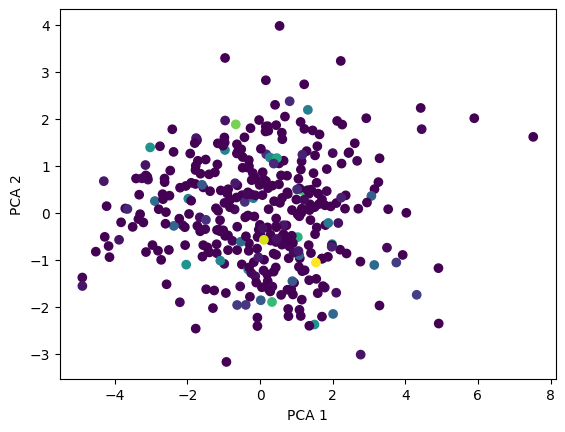

In [165]:
from matplotlib.colors import ListedColormap
# classes = ["주중", "주말"]
# colors = ListedColormap(['r','b'])
scatter = plt.scatter(pca_res[:,0], pca_res[:,1], c=labels[:,0])
# plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

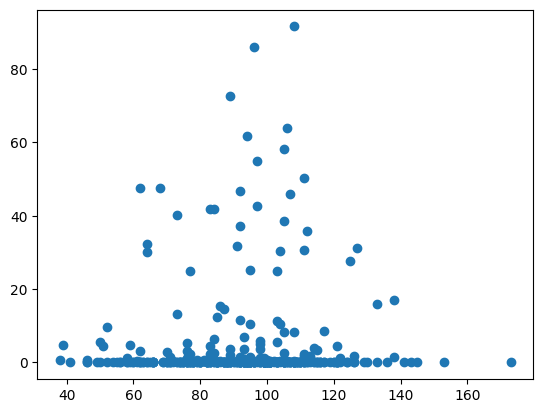

In [166]:
plt.scatter(data_crash_np.sum(axis=1), labels[:,0])

In [167]:
np.corrcoef(data_crash_np.sum(axis=1), labels[:,0])

array([[1.        , 0.03597851],
       [0.03597851, 1.        ]])

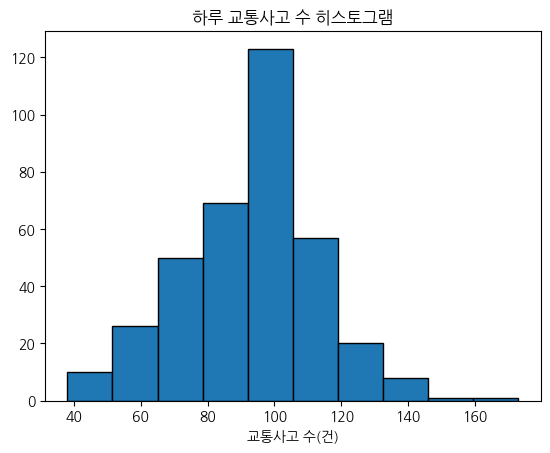

In [214]:
data_crash_sum = data_crash_np.sum(axis=1)
plt.hist(data_crash_sum, edgecolor='black', linewidth=1)
plt.title("하루 교통사고 수 히스토그램")
plt.xlabel("교통사고 수(건)")
plt.show()

In [181]:
t = 10

weather_means = [[] for _ in range(100//t)]
data_crash_sum = data_crash_np.sum(axis=1)
for i in range(data_crash.shape[0]):
    weather_means[int(labels[i,0]//t)].append(data_crash_sum[i])

for i in range(len(weather_means)):
    if len(weather_means[i])==0:
        weather_means[i] = 0
    else:
        weather_means[i] = sum(weather_means[i]) / len(weather_means[i])

weather_means

[np.float64(90.67415730337079),
 np.float64(97.83333333333333),
 np.float64(100.0),
 np.float64(92.875),
 np.float64(79.85714285714286),
 np.float64(104.33333333333333),
 np.float64(100.0),
 np.float64(89.0),
 np.float64(96.0),
 np.float64(108.0)]

In [209]:
plt.rcParams['font.family'] = 'NanumGothic'
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

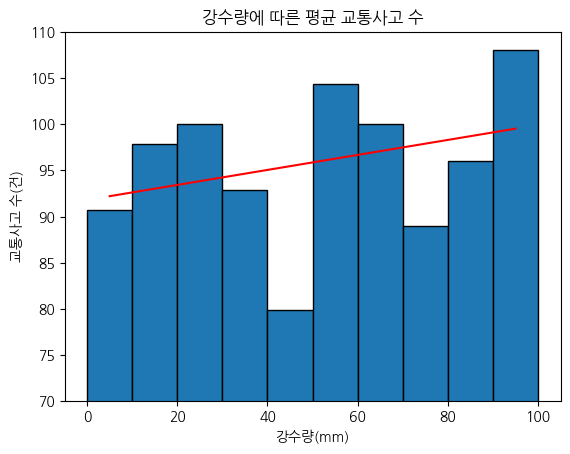

In [206]:
from sklearn.linear_model import LinearRegression
X = np.arange(10).reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X=X, y=weather_means)

data = X
pred = lin_model.predict(data)

plt.bar(range(5, 105, 10), weather_means, width=10, edgecolor = 'black', linewidth = 1)
plt.plot(X*10+5, pred, color='red')
plt.ylim(70, 110)
plt.title("강수량에 따른 평균 교통사고 수")
plt.xlabel("강수량(mm)")
plt.ylabel("교통사고 수(건)")
plt.show()

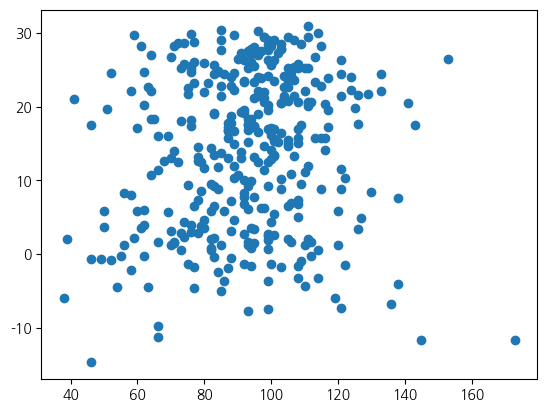

In [210]:
plt.scatter(data_crash_np.sum(axis=1), labels[:,1])

In [150]:
data_crash = pd.read_csv(f"Seoul_2023/CrashReport.csv", skiprows=1)
data_crash = data_crash[data_crash["사고년도"]=="사망[명]"]
data_crash.drop(columns=["사고년도"], inplace=True)
data_crash.replace("-", 0, inplace=True)
for i in range(1, 32):
    data_crash[f"{i:02d}일"] = data_crash[f"{i:02d}일"].map(lambda x: int(x))

data_crash_place = data_crash["시군구"].unique()

data_crash_pd = []
for i in range(365):
    row = []
    date = datetime.date(year=2023, month=1, day=1) + timedelta(days=i)
    row.append(date)
    for place in data_crash_place:
        data_temp = data_crash[data_crash["시군구"]==place]
        value = data_temp[data_temp['사고월']==f"{date.month:02d}월"][f"{date.day:02d}일"].iloc[0]
        row.append(value)
    data_crash_pd.append(row)

data_crash_pd = pd.DataFrame(data_crash_pd, columns=["일자"]+list(data_crash_place))
data_crash_pd

,일자,종로구,마포구,강서구,구로구,영등포구,동작구,관악구,강남구,강동구,...,광진구,강북구,금천구,용산구,성동구,동대문구,성북구,도봉구,은평구,서대문구
0,2023-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-01-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-01-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-27,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,2023-12-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
362,2023-12-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
363,2023-12-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
data_crash_pd['일자'] = pd.to_datetime(data_crash_pd['일자'])
data_crash_np = np.zeros((365, 25))
labels = np.zeros((365, 2))

data_weather = pd.read_csv("Seoul_2023/Rain.csv")
data_weather['날짜'] = pd.to_datetime(data_weather["날짜"])
data_weather.fillna(0, inplace=True)

data_tem = pd.read_csv("Seoul_2023/Temperature.csv")
data_tem['날짜'] = pd.to_datetime(data_tem["날짜"])
data_tem.fillna(0, inplace=True)

for i in range(365):
    labels[i, 0] = data_weather[data_weather['날짜']==data_crash_pd['일자'].iloc[i]]["강수량(mm)"].iloc[0]
    labels[i, 1] = data_tem[data_tem['날짜']==data_crash_pd['일자'].iloc[i]]["평균기온(℃)"].iloc[0]
    for j in range(25):
        data_crash_np[i,j] = data_crash_pd.iloc[i, j+1]

data_crash_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

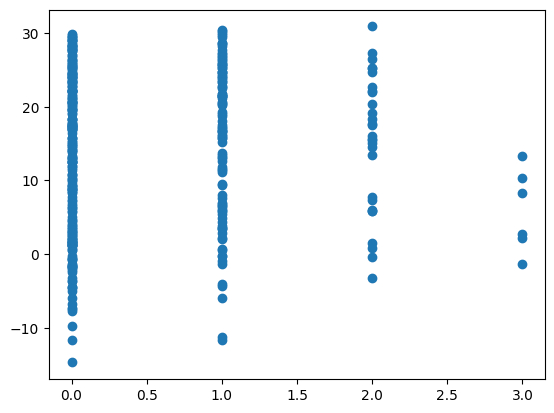

In [155]:
plt.scatter(data_crash_np.sum(axis=1), labels[:,1])